In [1]:
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator
from notebook_utils import configure_path, setup_matplotlib
from sklearn.linear_model import LinearRegression

In [2]:
configure_path()
setup_matplotlib()

## The role of Content Delivery Networks

The rise of CDNs has reshaped the Internet landscape, with a few providers now generating the majority of Internet traffic. To efficiently deliver content on a large scale, many of these networks have established replica servers within customer networks, or off-nets. These off-net deployments aim to reduce interdomain traffic and improve users’ download times.

We leverage the artifacts of Gigis et al. to assess the scale of off-net deployments by Venezuelan networks and compare it with those of other countries in the region.

We use these artifacts to identify the presence of off-net deployments from major content providers within networks registered across Latin America. We consider these eyeball populations at the organizational level, using as2org+ (https://github.com/NU-AquaLab/as2orgplus), to eliminate fluctuations in deployments across networks belonging to the same organization. We then combine these results with APNIC’s estimates of Autonomous System (AS) populations (https://labs.apnic.net/?p=526 and https://stats.labs.apnic.net/aspop) to calculate the percentage of a country’s user base connected to networks with off-net hosts.

In [3]:
def hg_formatter(data):
    o = []
    for d in data:
        dd = datetime.strptime(d, "%Y %b")
        for cc in data[d]:
            for asn in data[d][cc]:
                for hg in data[d][cc][asn]:
                    o.append((dd, cc, int(asn), hg))

    return pd.DataFrame(o, columns=["date", "cc", "asn", "hg"])

In [4]:
hg_filename = "data/processed/07-hgs/parsed_data.json"

with open(hg_filename, "r") as f:
    hgs = hg_formatter(json.load(f))

In [5]:
hgs.head()

,date,cc,asn,hg
0,2013-10-01,MX,6342,akamai
1,2013-10-01,MX,6503,akamai
2,2013-10-01,MX,6503,google
3,2013-10-01,MX,7438,akamai
4,2013-10-01,MX,8151,akamai


In [6]:
def aspop_formatter(data):
    o = []

    for aut in data["Data"]:
        o.append((int(aut["AS"]), aut["CC"], float(aut["Percent of CC Pop"])))

    return pd.DataFrame(o, columns=["asn", "cc", "pct_cc"])

In [7]:
aspop_filename = "data/processed/07-hgs/Internet_Population_Estimation.json"
aspop = aspop_formatter(json.load(open(aspop_filename, "r")))

In [8]:
aspop.head()

,asn,cc,pct_cc
0,55836,IN,48.30
1,4134,CN,32.29
2,45609,IN,26.19
3,4837,CN,16.67
4,9808,CN,13.84


In [9]:
aspop.loc[aspop["cc"] == "VE"].sort_values("pct_cc", ascending=False).head()

,asn,cc,pct_cc
155,8048,VE,23.35
262,6306,VE,12.79
293,21826,VE,11.67
355,264731,VE,8.69
474,264628,VE,5.50


In [10]:
as2orgoplus = pd.read_csv("data/processed/07-hgs/as2orgplus_2022_04_01.csv")

In [11]:
as2orgoplus.head()

,org_id,asn
0,0,9989
1,0,23686
2,0,27272
3,0,43147
4,0,16397


In [12]:
aspop = aspop.join(
    as2orgoplus.set_index(
        [
            "asn",
        ]
    ),
    on=[
        "asn",
    ],
    how="left",
    rsuffix="_agg",
)

In [13]:
aspop_org = aspop.groupby(["org_id", "cc"]).sum().reset_index()

In [14]:
aspop = aspop.join(
    aspop_org.set_index(["org_id", "cc"]),
    on=["org_id", "cc"],
    how="left",
    rsuffix="_org",
)

In [15]:
aspop.head()

,asn,cc,pct_cc,org_id,asn_org,pct_cc_org
0,55836,IN,48.30,3016.0,55836.0,48.30
1,4134,CN,32.29,144.0,4406104.0,39.15
2,45609,IN,26.19,796.0,79667.0,30.08
3,4837,CN,16.67,1458.0,14766.0,16.71
4,9808,CN,13.84,1776.0,944386.0,34.53


In [16]:
aspop.shape

(27355, 6)

In [17]:
hgs = hgs.join(
    aspop.set_index(
        [
            "asn",
            "cc",
        ]
    ),
    on=[
        "asn",
        "cc",
    ],
    how="left",
    rsuffix="_agg",
)

In [18]:
hgs.head()

,date,cc,asn,hg,pct_cc,org_id,asn_org,pct_cc_org
0,2013-10-01,MX,6342,akamai,0.00,14780.0,55991.0,0.00
1,2013-10-01,MX,6503,akamai,0.10,7669.0,17675.0,0.74
2,2013-10-01,MX,6503,google,0.10,7669.0,17675.0,0.74
3,2013-10-01,MX,7438,akamai,0.71,8941.0,7438.0,0.71
4,2013-10-01,MX,8151,akamai,30.58,5038.0,8151.0,30.58


In [19]:
tmp = hgs.loc[(hgs["hg"] == "akamai")]
agg = tmp.groupby(["date", "cc"])["pct_cc"].sum().reset_index()

In [20]:
agg.head()

,date,cc,pct_cc
0,2013-10-01,AR,23.96
1,2013-10-01,BO,4.72
2,2013-10-01,BR,25.65
3,2013-10-01,CL,39.17
4,2013-10-01,CO,40.17


In [21]:
def _plot(ax, agg, hg, label_on=False):
    country_styles = {
        "AR": {"alpha": 0.75, "lw": 2, "color": "C0", "label": "AR"},
        "AW": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "BZ": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "BO": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "BQ": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "BR": {"alpha": 0.75, "lw": 2, "color": "C1", "label": "BR"},
        "CL": {"alpha": 0.75, "lw": 2, "color": "C2", "label": "CL"},
        "UY": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "CR": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "CU": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "CW": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "DO": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "EC": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "SV": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "FK": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "GF": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "GT": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "GY": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "HT": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "HN": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "MX": {"alpha": 0.75, "lw": 2, "color": "C3", "label": "MX"},
        "NI": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "PA": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "PY": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "PE": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "SX": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "GS": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "SR": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "TT": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
        "CO": {"alpha": 0.75, "lw": 2, "color": "C5", "label": "CO"},
        "VE": {"alpha": 0.75, "lw": 2, "color": "purple", "label": "VE"},
    }

    ax.yaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")
    ax.xaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")

    p = agg.pivot(index="cc", columns="date")["pct_cc_org"]
    t = p.columns
    idx = p.index
    p = p.to_numpy()
    p = np.nan_to_num(p)

    i = 0
    for j in range(len(idx)):
        x = p[j, :]
        cc = idx[j]

        if cc in ["AR", "BR", "MX", "CL", "CO", "VE"]:
            color = country_styles[cc]["color"]
            lw = 2
            alpha = 0.75
            if label_on:
                label = f"{cc}"
            else:
                label = None
            i += 1
        else:
            color = "grey"
            lw = 0.1
            alpha = 0.5
            label = None

        ax.plot_date(
            t,
            x,
            xdate=True,
            ydate=False,
            tz="UTC",
            alpha=alpha,
            lw=lw,
            fmt="-",
            marker="None",
            color=color,
            label=label,
        )

    ax.set_ylabel("%", fontsize=20)
    ax.tick_params(labelsize=20)

    ax.yaxis.grid(
        True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major"
    )
    ax.xaxis.grid(
        True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major"
    )

    ax.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
    ax.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

    ax.xaxis.set_major_formatter(DateFormatter("'%y"))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.set_title(hg, fontsize=20)

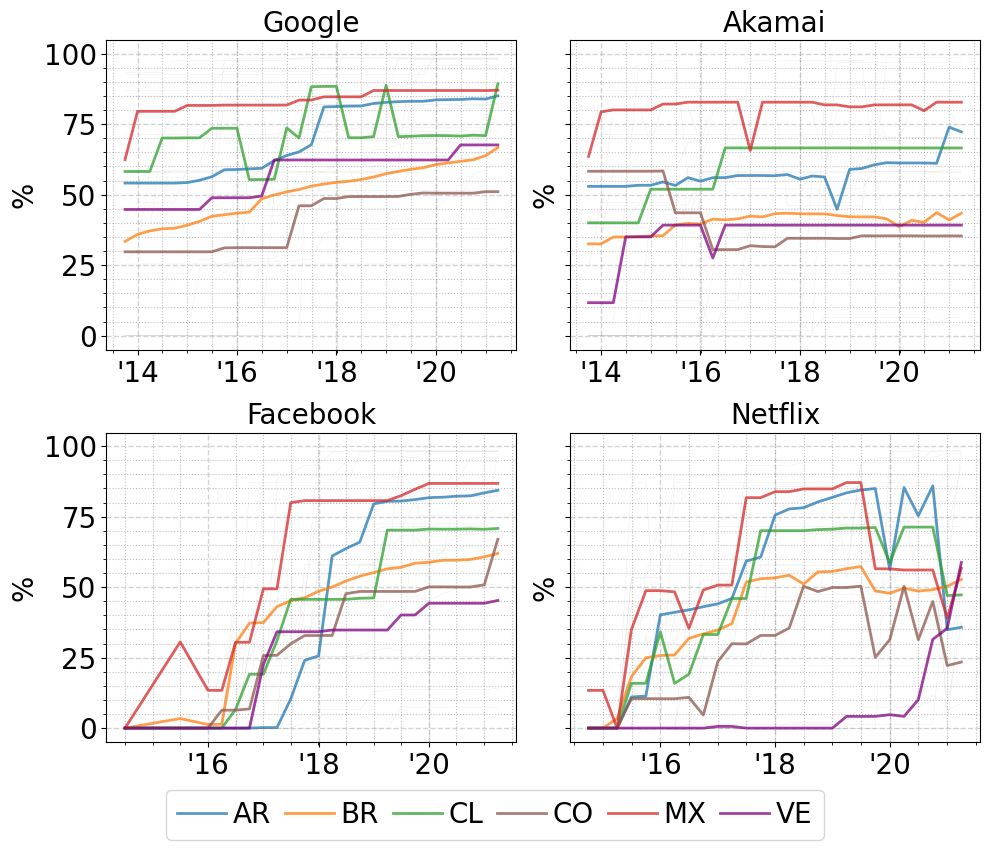

In [22]:
fig, _ax = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

i = 0
for hg in ["google", "akamai", "facebook", "netflix"]:

    tmp = hgs.loc[(hgs["hg"] == hg)]
    agg = (
        tmp.drop_duplicates(["org_id", "cc", "date"])
        .groupby(["date", "cc"])["pct_cc_org"]
        .sum()
        .reset_index()
    )

    _plot(_ax[int(i / 2)][i % 2], agg, hg.capitalize(), i == 0)

    i += 1

lgd = fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, -0.025),
    ncol=6,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

fig.tight_layout()
fig.savefig(
    "figures/07-cdn_deployment.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

The figure presents four time series for Google, Akamai, Facebook (Meta), and Netflix, which shows the percentage of the population in each country connected to networks hosting off-net servers over the period from 2013 to 2021.

Our analysis reveals a contrasting narrative for Venezuela compared to other countries in the region. Early in the observation period (2013), before Venezuela’s crisis unfolded, Google and Akamai had established their presence in the country. Content providers that rolled out their networks later, such as Facebook and Netflix, have had more modest and delayed deployments in Venezuela.

In [23]:
for hg in ["google", "akamai", "facebook", "netflix"]:
    tmp = hgs.loc[(hgs["hg"] == hg)]
    tmp = tmp.dropna()
    agg = tmp.groupby(["date", "cc"])["pct_cc_org"].sum().reset_index()
    agg = agg.loc[agg["date"] == agg["date"].max()]
    agg = agg.sort_values("pct_cc_org", ascending=False)
    agg["rank"] = 1 + np.arange(agg.shape[0])

    print(
        hg,
        agg.shape[0],
        agg.loc[agg["cc"] == "VE"]["rank"].iloc[0],
        agg.loc[agg["cc"] == "VE"]["pct_cc_org"].iloc[0],
    )

google 27 20 67.63
akamai 22 19 39.18
facebook 25 21 45.269999999999996
netflix 24 12 58.76


In [24]:
prev = pd.DataFrame()

for hg in ["google", "akamai", "facebook", "netflix"]:
    _prev = []

    tmp = hgs.loc[(hgs["hg"] == hg)]
    agg = tmp.groupby(["date", "cc"])["pct_cc_org"].sum().reset_index()

    p = agg.pivot(index="cc", columns="date")["pct_cc_org"]
    t = p.columns
    idx = p.index
    p = np.nan_to_num(p)

    _prev = pd.DataFrame({"cc": idx, "pct_cc_org": p.mean(axis=1)})
    _prev["hg"] = np.repeat(hg, _prev.shape[0])

    prev = pd.concat([prev, _prev])

In [25]:
prev.head()

,cc,pct_cc_org,hg
0,AR,96.315161,google
1,AW,93.957419,google
2,BO,97.597742,google
3,BR,72.837742,google
4,BZ,63.853871,google


In [26]:
for hg in ["google", "akamai", "facebook", "netflix"]:
    agg = prev.loc[(prev["hg"] == hg)]
    agg = agg.sort_values("pct_cc_org", ascending=False)
    agg["rank"] = 1 + np.arange(agg.shape[0])

    print(
        f'{hg} {agg.loc[agg["cc"] == "VE"]["rank"].iloc[0]}/{agg.shape[0]} ({agg.loc[agg["cc"] == "VE"]["pct_cc_org"].iloc[0]:.02f})'
    )

google 19/27 (56.88)
akamai 18/22 (35.74)
facebook 21/25 (28.33)
netflix 23/25 (5.87)


When averaging the percentage of users in networks hosting off- net servers across each country during this 8-year period, Venezuela’s ranking across providers varies but it is largely in the bottom set for the region: 19/27 (56.88%) for Google, 18/22 (35.74%) for Akamai, 21/25 (28.33%) for Facebook (Meta), and 23/25 (5.87%) for Netflix.


In [27]:
for hg in ["google", "akamai", "facebook", "netflix"]:
    agg = prev.loc[(prev["hg"] == hg)]
    agg = agg.sort_values("pct_cc_org", ascending=False)
    agg["rank"] = 1 + np.arange(agg.shape[0])

    print("-------")
    print(hg)
    display(agg)

-------
google


,cc,pct_cc_org,hg,rank
18,PA,180.680645,google,1
16,MX,172.016774,google,2
2,BO,97.597742,google,3
0,AR,96.315161,google,4
1,AW,93.957419,google,5
25,UY,89.077097,google,6
21,SR,88.576452,google,7
15,HT,87.205806,google,8
10,DO,81.274839,google,9
12,GT,80.073226,google,10


-------
akamai


,cc,pct_cc_org,hg,rank
12,MX,120.057097,akamai,1
14,PA,89.876452,akamai,2
20,UY,87.384194,akamai,3
4,CL,86.902581,akamai,4
1,BO,79.284839,akamai,5
7,DO,78.214194,akamai,6
15,PE,71.470645,akamai,7
19,TT,71.247097,akamai,8
6,CR,68.389355,akamai,9
0,AR,66.501290,akamai,10


-------
facebook


,cc,pct_cc_org,hg,rank
15,MX,137.333333,facebook,1
17,PA,74.052500,facebook,2
23,UY,70.046250,facebook,3
20,SR,69.677917,facebook,4
2,BO,68.554583,facebook,5
3,BR,61.616667,facebook,6
14,HT,59.098750,facebook,7
7,CR,58.535833,facebook,8
18,PE,57.921250,facebook,9
19,PY,54.909583,facebook,10


-------
netflix


,cc,pct_cc_org,hg,rank
14,MX,135.889630,netflix,1
16,PA,71.997778,netflix,2
23,UY,67.736667,netflix,3
6,CR,63.197407,netflix,4
1,BO,62.141111,netflix,5
0,AR,60.777778,netflix,6
2,BR,58.632593,netflix,7
22,TT,56.537407,netflix,8
8,DO,53.830741,netflix,9
18,PY,49.827407,netflix,10


In [28]:
def _plot_all(ax, agg, hg, label_on=False):
    colors = {
        "MX": "C0",
        "AR": "C1",
        "BR": "C2",
        "CL": "C3",
        "UY": "C4",
        "CR": "C5",
        "EC": "C6",
        "PE": "C7",
        "VE": "C8",
        "PA": "C9",
        "CO": "C10",
        "HN": "C11",
        "CW": "C12",
        "TT": "C13",
        "GT": "C14",
        "DO": "C15",
        "BO": "C16",
        "SV": "C17",
        "BZ": "C18",
        "HT": "C19",
        "AW": "C20",
        "PY": "C21",
        "SR": "C22",
        "NI": "C23",
        "GY": "C24",
        "SX": "C25",
        "CU": "C26",
    }

    fmts = {
        "MX": "-",
        "AR": "--",
        "BR": ":",
        "CL": "-.",
        "UY": "-",
        "CR": "--",
        "EC": ":",
        "PE": "-.",
        "VE": "-",
        "PA": "--",
        "CO": ":",
        "HN": "-.",
        "CW": "-",
        "TT": "--",
        "GT": ":",
        "DO": "-.",
        "BO": "-",
        "SV": "--",
        "BZ": ":",
        "HT": "-.",
        "AW": "-",
        "PY": "--",
        "SR": ":",
        "NI": "-.",
        "GY": "-",
        "SX": "--",
        "CU": ":",
    }

    ax.yaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")
    ax.xaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")

    p = agg.pivot(index="cc", columns="date")["pct_cc_org"]
    t = p.columns
    idx = p.index
    p = p.to_numpy()
    p = np.nan_to_num(p)

    for j in range(len(idx)):
        x = p[j, :]
        cc = idx[j]

        if cc == "VE":
            lw = 3
        else:
            lw = 1
        alpha = 0.75
        if label_on:
            label = f"{cc}"
        else:
            label = None

        ax.plot_date(
            t,
            x,
            xdate=True,
            ydate=False,
            tz="UTC",
            alpha=alpha,
            lw=lw,
            fmt=fmts[cc],
            color=colors[cc],
            label=label,
        )

    ax.set_ylabel("%", fontsize=20)
    ax.tick_params(labelsize=20)

    ax.yaxis.grid(
        True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major"
    )
    ax.xaxis.grid(
        True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major"
    )

    ax.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
    ax.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

    ax.xaxis.set_major_formatter(DateFormatter("'%y"))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.set_title(hg, fontsize=20)

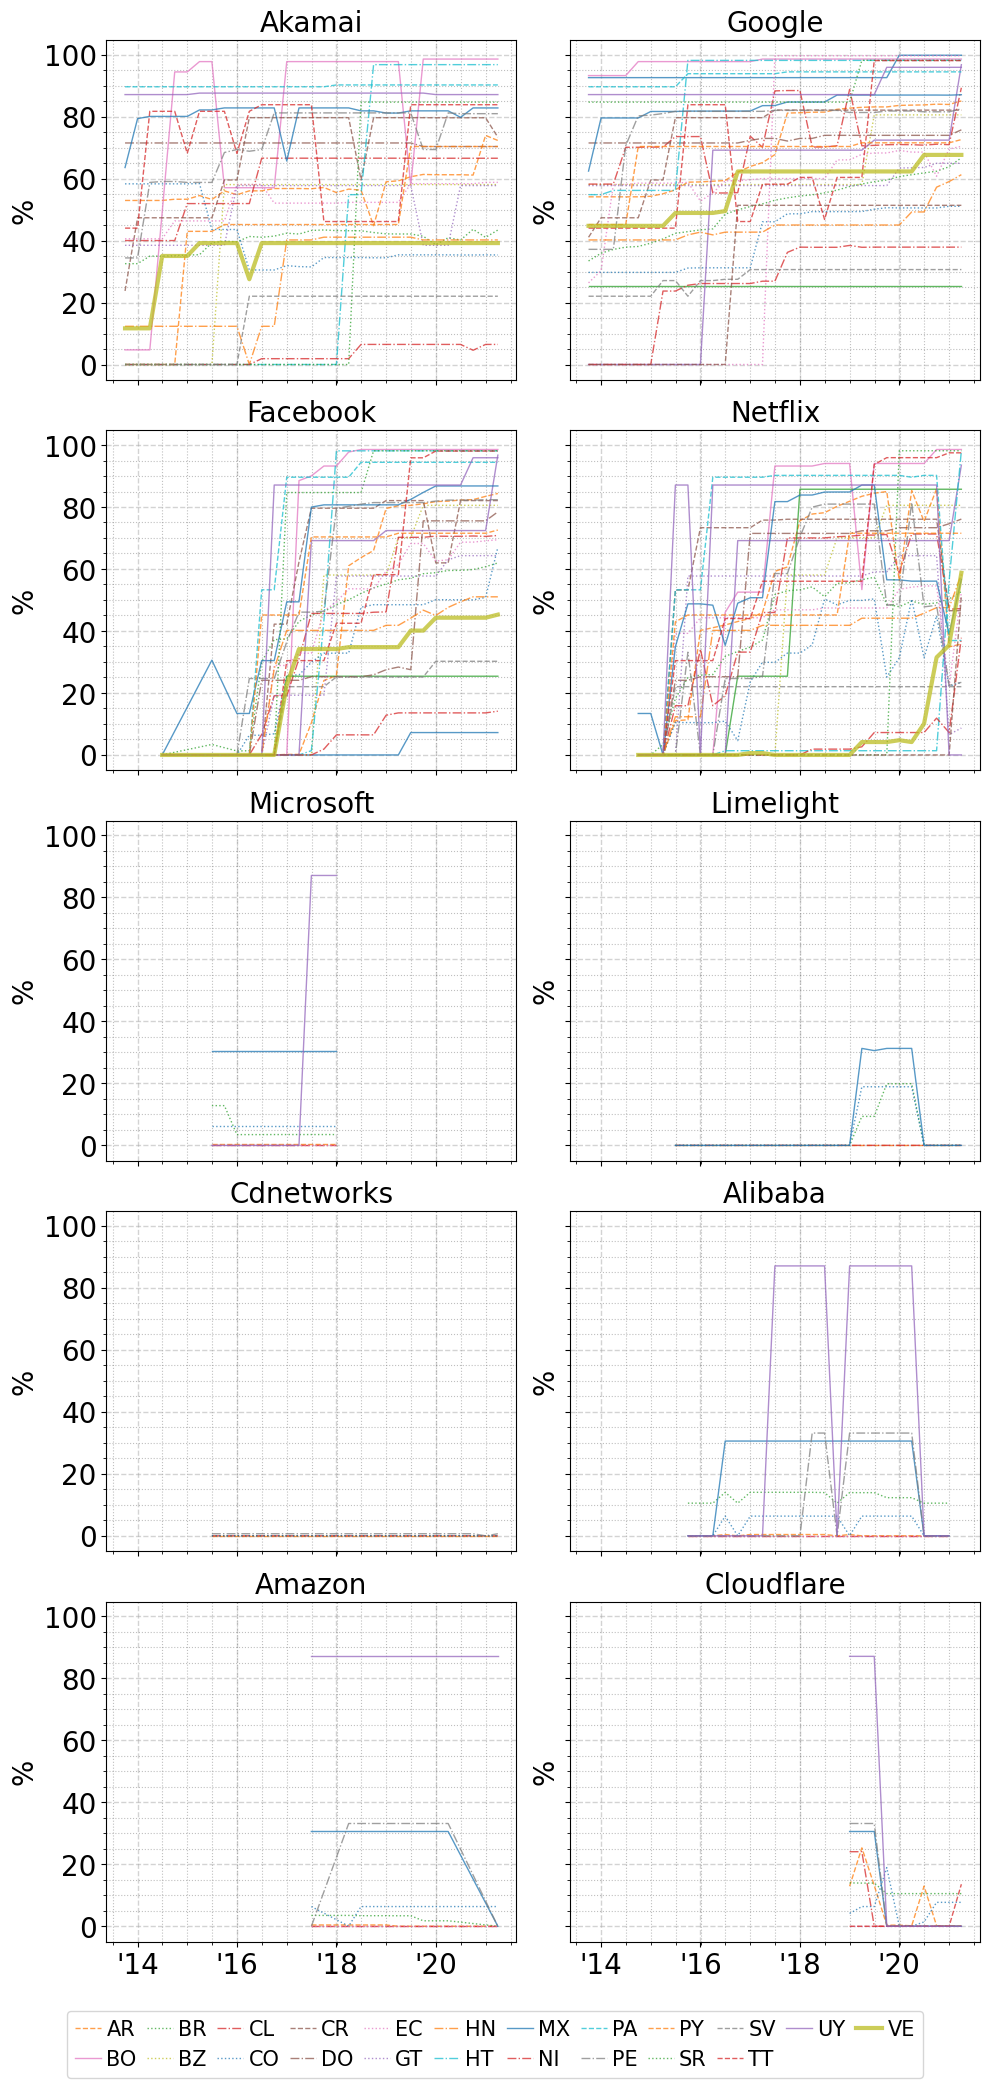

In [29]:
fig, _ax = plt.subplots(5, 2, figsize=(10, 20), sharex=True, sharey=True)

i = 0
for hg in hgs.drop_duplicates("hg")["hg"].values:

    tmp = hgs.loc[(hgs["hg"] == hg)]
    agg = (
        tmp.drop_duplicates(["org_id", "cc", "date"])
        .groupby(["date", "cc"])["pct_cc_org"]
        .sum()
        .reset_index()
    )

    _plot_all(_ax[int(i / 2)][i % 2], agg, hg.capitalize(), i == 0)
    i += 1

lgd = fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, -0.025),
    ncol=12,
    frameon=True,
    fontsize=15,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.25,
)

fig.tight_layout()
fig.savefig(
    "figures/18-cdn_deployment_all.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

This pattern holds for other hypergiants, including Cloudflare, Microsoft, Limelight (now Edg.io), CDN Networks, Alibaba, and Amazon, which have minimal off-net presence in Latin America and no presence in Venezuela.


In [30]:
hgs.drop_duplicates("hg")["hg"].values

array(['akamai', 'google', 'facebook', 'netflix', 'microsoft',
       'limelight', 'cdnetworks', 'alibaba', 'amazon', 'cloudflare'],
      dtype=object)

In [31]:
hgs.drop_duplicates("cc")["cc"].values

array(['MX', 'AR', 'BR', 'CL', 'UY', 'CR', 'EC', 'PE', 'VE', 'PA', 'CO',
       'HN', 'CW', 'TT', 'GT', 'DO', 'BO', 'SV', 'BZ', 'HT', 'AW', 'PY',
       'SR', 'NI', 'GY', 'SX', 'CU'], dtype=object)

In [32]:
def compute_lr(t, x):
    t = np.array(t).reshape(-1, 1)
    x = np.array(x).reshape(-1, 1)

    regressor = LinearRegression()
    regressor.fit(t, x)
    s = regressor.score(t, x)
    m = regressor.coef_
    b = regressor.intercept_

    return m[0][0], b[0], s

In [33]:
lrs = pd.DataFrame()

for hg in ["google", "akamai", "facebook", "netflix"]:
    _lrs = []

    tmp = hgs.loc[(hgs["hg"] == hg)]
    agg = tmp.groupby(["date", "cc"])["pct_cc"].sum().reset_index()

    p = agg.pivot(index="cc", columns="date")["pct_cc"]
    t = p.columns
    idx = p.index
    p = np.nan_to_num(p)

    for i in range(p.shape[0]):
        m, b, s = compute_lr(np.arange(p.shape[1]), p[i, :])

        _lrs.append([hg, idx[i], m, b, s])

    lrs = pd.concat([lrs, pd.DataFrame(_lrs, columns=["hg", "cc", "m", "b", "s"])])

In [34]:
for hg in ["google", "akamai", "facebook", "netflix"]:
    tmp = lrs.loc[(lrs["hg"] == hg)]
    tmp = tmp.sort_values("m", ascending=False)
    tmp["rank"] = 1 + np.arange(tmp.shape[0])

    print(hg, tmp.shape[0], tmp.loc[tmp["cc"] == "VE"]["rank"].iloc[0])

google 27 14
akamai 22 14
facebook 25 21
netflix 25 22


In [35]:
for hg in ["google", "akamai", "facebook", "netflix"]:
    display(lrs.loc[lrs["hg"] == hg].sort_values("m", ascending=False))

,hg,cc,m,b,s
8,google,CU,4.820323,-20.888065,0.750000
13,google,GY,3.195556,0.538266,0.715450
23,google,SX,2.360903,-3.934839,0.712500
24,google,TT,1.801931,40.259093,0.544544
15,google,HT,1.572230,63.622359,0.577279
17,google,NI,1.376460,5.936976,0.764934
7,google,CR,1.156310,56.845020,0.587436
3,google,BR,1.133653,25.759395,0.969978
10,google,DO,1.105464,41.397399,0.609736
5,google,CL,1.060315,45.016895,0.815893


,hg,cc,m,b,s
11,akamai,HT,4.446008e+00,-28.823992,0.759761
17,akamai,SR,3.891629e+00,-25.602823,0.712500
3,akamai,BZ,2.153468e+00,10.767339,0.575000
1,akamai,BO,2.147532e+00,47.071855,0.413568
16,akamai,PY,2.098274e+00,11.819113,0.740963
6,akamai,CR,1.374960e+00,47.764960,0.604502
10,akamai,HN,1.352141e+00,8.056593,0.688904
0,akamai,AR,1.202456e+00,13.057681,0.433024
15,akamai,PE,1.126827e+00,54.568246,0.591516
4,akamai,CL,9.616976e-01,44.197117,0.706865


,hg,cc,m,b,s
14,facebook,HT,5.874178,-8.454300,0.750980
22,facebook,TT,5.335130,-11.218167,0.937366
2,facebook,BO,5.183013,8.949933,0.662627
20,facebook,SR,4.814065,14.316167,0.672702
0,facebook,AR,4.659857,-14.031267,0.908018
4,facebook,BZ,4.654791,-9.684267,0.849907
12,facebook,GY,4.289522,-0.858667,0.733526
18,facebook,PE,3.918883,12.854100,0.800802
23,facebook,UY,3.838239,25.906500,0.543289
7,facebook,CR,3.651383,16.544933,0.618263


,hg,cc,m,b,s
7,netflix,CW,4.530177,-9.736005,0.822317
1,netflix,BO,4.474719,3.969762,0.751802
3,netflix,BZ,4.283199,-15.814180,0.843316
19,netflix,SR,3.775000,-27.263889,0.519231
22,netflix,TT,3.739518,7.923677,0.906119
11,netflix,GY,3.402063,5.342804,0.665316
8,netflix,DO,2.965549,15.251931,0.720303
4,netflix,CL,2.742863,9.482778,0.670158
0,netflix,AR,2.427057,15.001587,0.540429
18,netflix,PY,2.341508,18.391138,0.740515


In [36]:
hgs.loc[(hgs["cc"] == "VE") & (hgs["hg"] == "facebook") & (hgs["asn"] == 8048)]

,date,cc,asn,hg,pct_cc,org_id,asn_org,pct_cc_org


In [37]:
hgs.loc[(hgs["cc"] == "VE") & (hgs["hg"] == "netflix") & (hgs["asn"] == 8048)]

,date,cc,asn,hg,pct_cc,org_id,asn_org,pct_cc_org
45712,2021-04-01,VE,8048,netflix,23.35,18923.0,8048.0,23.35


In [38]:
hgs.loc[(hgs["cc"] == "VE") & (hgs["asn"] == 8048)].drop_duplicates("hg")

,date,cc,asn,hg,pct_cc,org_id,asn_org,pct_cc_org
157,2013-10-01,VE,8048,google,23.35,18923.0,8048.0,23.35
866,2014-07-01,VE,8048,akamai,23.35,18923.0,8048.0,23.35
45712,2021-04-01,VE,8048,netflix,23.35,18923.0,8048.0,23.35


We focus on the state-controlled network CANTV-AS8048 to examine if it has received off-net deployments during this period. Notably, Google and Akamai had already established a presence in the country, including CANTV, prior to Venezuela’s decline. In contrast, networks with later deployments, such as Netflix and Facebook, took a different approach. Facebook, for instance, did not deploy servers within CANTV, and Netflix only began doing so in 2021, nearly a decade after its rapid expansion across the LACNIC region had started.